In [1]:
# Import 
import os
import time
import json
import datetime
import sys

import pandas as pd
import numpy as np
from matplotlib import rcParams

from pathlib import Path
from tyssue import Sheet
from tyssue.io import hdf5

from tyssue.dynamics.sheet_gradients import height_grad
from tyssue.dynamics import units, effectors, model_factory
from tyssue.solvers.quasistatic import QSSolver
from tyssue.draw import sheet_view
import matplotlib.pyplot as plt
%matplotlib inline
rcParams['figure.dpi'] = 200

sys.path.append("..")
from peripodial.polarity import model
from peripodial.dynamics import EllipsoidLameGeometry as geom
from peripodial.anisotropy import anysotropy as aniso
from peripodial.anisotropy import face_orientation
from peripodial.polarity import update_weights
from peripodial.draw import draw_half_sheet

vispy  won't work


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
SIM_DIR = Path('/home/lglepin/Simulations/')
today = datetime.date.today()

sim_save_dir = SIM_DIR/f'{today.isoformat()}_YolkElasticity'

try:
    sim_save_dir.mkdir(parents=True, exist_ok=True)
except FileExistsError:
    pass

dsets = hdf5.load_datasets('../json_hdf5/lumen_elasticity.hdf5',
                               data_names=['vert', 'edge', 'face'])

with open('../json_hdf5/lumen_elasticity.json', 'r+') as fp:
    specs = json.load(fp)

sheet = Sheet('spherical', dsets)

sheet.update_specs(specs)
geom.update_all(sheet)


In [4]:
sheet.specs

{'face': {'x': 0.0,
  'y': 0.0,
  'z': 0.0,
  'num_sides': 6,
  'area': 1.0,
  'perimeter': 1.0,
  'is_alive': 1,
  'id': 0,
  'unique_id_max': 1652,
  'prefered_perimeter': 3.8},
 'vert': {'x': 0.0,
  'y': 0.0,
  'z': 0.0,
  'is_active': 1,
  'rho': 0.0,
  'height': 0.0,
  'basal_shift': 4.0,
  'unique_id_max': 3300,
  'barrier_elasticity': 280},
 'edge': {'srce': 0,
  'trgt': 0,
  'face': 0,
  'dx': 0.0,
  'dy': 0.0,
  'dz': 0.0,
  'nx': 0.0,
  'ny': 0.0,
  'nz': 0.0,
  'sx': 0.0,
  'sy': 0.0,
  'sz': 0.0,
  'tx': 0.0,
  'ty': 0.0,
  'tz': 0.0,
  'fx': 0.0,
  'fy': 0.0,
  'fz': 0.0,
  'length': 1.0,
  'is_active': 1,
  'ux': 0.0,
  'uy': 0.0,
  'uz': 0.0,
  'unique_id_max': 9900},
 'settings': {'geometry': 'spherical',
  'height_axis': 'z',
  'lumen_prefered_vol': 5700,
  'lumen_vol_elasticity': 0.01,
  'threshold_length': 0.01,
  'rosette_kwargs': {'threshold_length': 0.01, 'p_4': 0.01, 'p_5': 0.001},
  'barrier_radius': 100,
  'lumen_vol': 5641.992491306501}}

Text(0, 0.5, 'D-V axis')

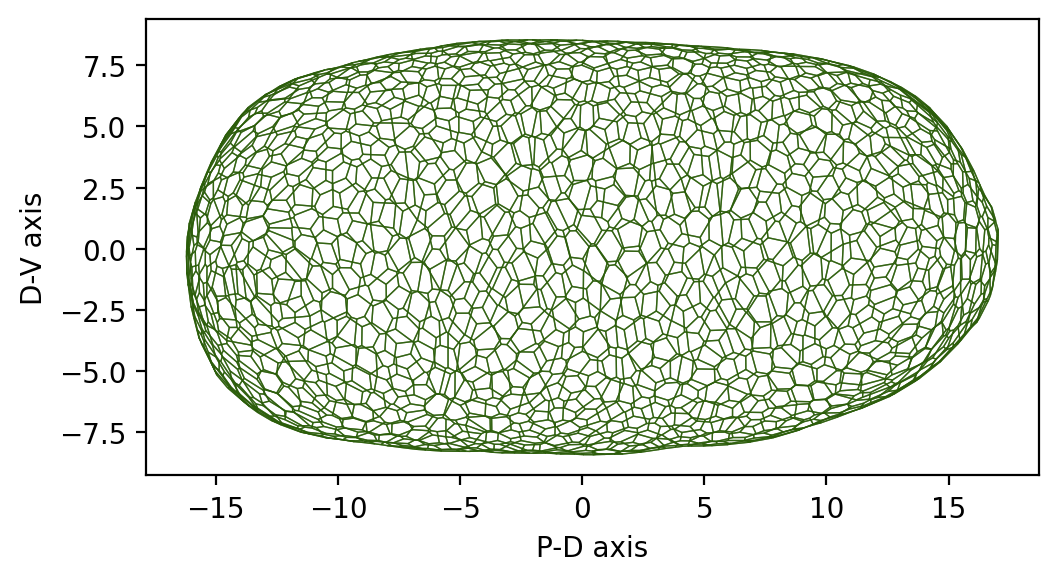

In [5]:
fig, ax = sheet_view(sheet, coords=["z", "x"])
ax.set_xlabel('P-D axis')
ax.set_ylabel('D-V axis')


In [6]:
sheet.face_df["area"].mean()

1.005847100697268

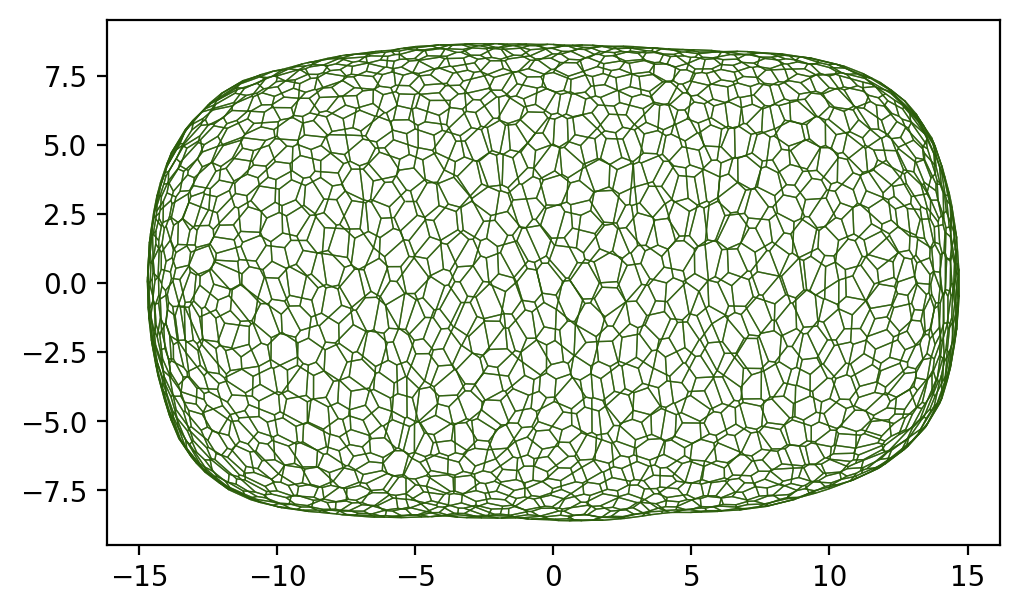

In [7]:
specs['settings']["barrier_radius"] = 14.7
sheet.update_specs(specs, reset=True)
solver = QSSolver(with_t1=False, with_t3=False)
res = solver.find_energy_min(sheet, geom, model, options={"gtol": 1e-4})
fig, ax = sheet_view(sheet, coords=["z", "x"])

In [8]:
#### verify that the function update_weight works
"""change = []
sheet_copy = sheet.copy()
theta = np.pi / 3

for i in range(10): 
    
    print(f"{i+1} / 10", end=" ")
    z_orientation = update_weights(
        sheet_copy, 
        threshold_angle=theta, 
        below_threshold=0.5,
        above_threshold=1.0,
    )
    solver = QSSolver(with_t1=False, with_t3=False)
    res = solver.find_energy_min(sheet_copy, geom, model, options={"gtol": 1e-4})
    change.append((z_orientation < np.sin(theta)**2).sum()  /sheet_copy.Ne)


sheet_copy1 = sheet_copy.copy()
sheet_copy1.edge_df = sheet_copy1.edge_df[sheet.edge_df["sy"] > 0] 

draw_specs = {'vert': {
            'visible': False
            },
        'edge': {
            'color': sheet_copy1.edge_df["weight"],
            'colormap': "coolwarm",
            'width': sheet_copy1.edge_df["weight"]
            #'zorder': depth.values
            }
        }

fig, ax = sheet_view(sheet_copy1, ["z", "x"], mode='2D', **draw_specs)
ax.set_facecolor('#101010')
print(change)"""


'change = []\nsheet_copy = sheet.copy()\ntheta = np.pi / 3\n\nfor i in range(10): \n    \n    print(f"{i+1} / 10", end=" ")\n    z_orientation = update_weights(\n        sheet_copy, \n        threshold_angle=theta, \n        below_threshold=0.5,\n        above_threshold=1.0,\n    )\n    solver = QSSolver(with_t1=False, with_t3=False)\n    res = solver.find_energy_min(sheet_copy, geom, model, options={"gtol": 1e-4})\n    change.append((z_orientation < np.sin(theta)**2).sum()  /sheet_copy.Ne)\n\n\nsheet_copy1 = sheet_copy.copy()\nsheet_copy1.edge_df = sheet_copy1.edge_df[sheet.edge_df["sy"] > 0] \n\ndraw_specs = {\'vert\': {\n            \'visible\': False\n            },\n        \'edge\': {\n            \'color\': sheet_copy1.edge_df["weight"],\n            \'colormap\': "coolwarm",\n            \'width\': sheet_copy1.edge_df["weight"]\n            #\'zorder\': depth.values\n            }\n        }\n\nfig, ax = sheet_view(sheet_copy1, ["z", "x"], mode=\'2D\', **draw_specs)\nax.set_fac

In [9]:
aniso(sheet, coords = ['x','y','z'])

face
0       0.131831
1       0.270924
2       0.219134
3       0.194300
4       0.274459
          ...   
1647    0.461292
1648    0.116289
1649    0.267763
1650    0.188151
1651    0.089357
Name: anisotropy, Length: 1652, dtype: float64

In [10]:
truc = (sheet.face_df['anisotropy']>0.5)
print(truc.to_string(index=False))

face
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
 True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
 True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
 True
False
False
False
False
 True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
 True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False

In [11]:
sheet.face_df.columns

Index(['x', 'y', 'z', 'num_sides', 'area', 'perimeter', 'is_alive', 'face_o',
       'opposite', 'height', 'rho', 'vol', 'phi', 'theta', 'area_elasticity',
       'prefered_area', 'contractility', 'id', 'unique_id', 'apoptosis',
       'current_traction', 'radial_tension', 'prefered_perimeter',
       'perimeter_elasticity', 'anisotropy'],
      dtype='object')

/home/lglepin/miniforge3/envs/tyssue/lib/python3.10/site-packages/tyssue/draw/plt_draw.py:435: UserWarning: Attempting to draw a colormap with a uniform value
  warnings.warn("Attempting to draw a colormap " "with a uniform value")


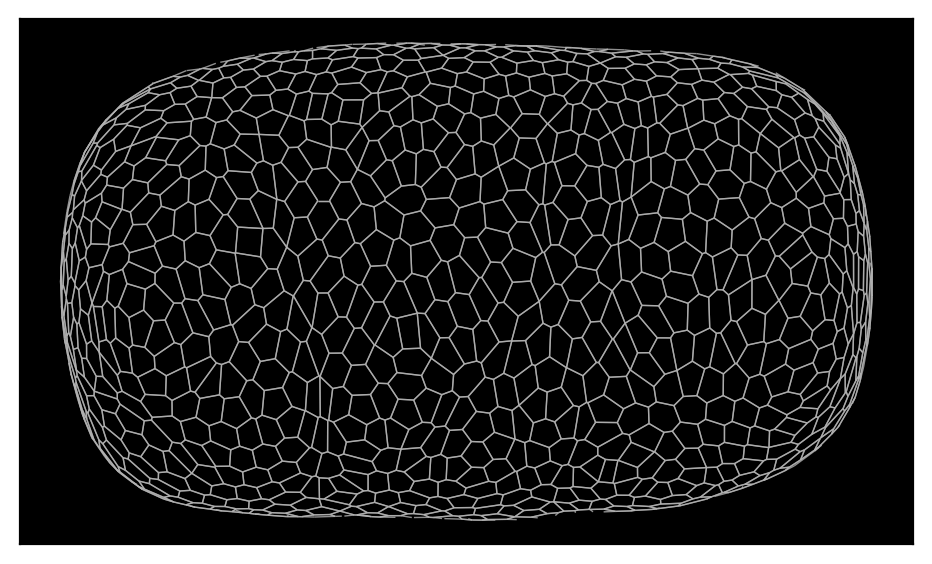

In [12]:
fig, ax = draw_half_sheet(sheet, ax=None)
ax.set_facecolor("black")

In [13]:
aniso_cell_values = [] 
theta = np.pi / 3
bts = np.arange(1, 10, 0.5)

for i, above_threshold in enumerate(bts):
    
    print(f"{i+1} / {10}", end=" ")
    update_weights(
        sheet, 
        threshold_angle=theta, 
        below_threshold=1,
        above_threshold=above_threshold,
    )
    geom.update_all(sheet)
    solver = QSSolver(with_t1=True, with_t3=False)
    res = solver.find_energy_min(sheet, geom, model, options={"gtol": 1e-4})
    sheet.face_df['anisotropy'] = aniso(sheet, coords = ['x','y','z'])
    center = np.abs(sheet.face_df["z"]) < sheet.face_df["z"].max()*0.75
    aniso_cell = sheet.face_df.loc[center, 'anisotropy'].mean()
    aniso_cell_values.append(aniso_cell)

aniso_cell_values = np.array(aniso_cell_values)
print(aniso_cell_values)


1 / 10 2 / 10 3 / 10 4 / 10 5 / 10 6 / 10 

/home/lglepin/miniforge3/envs/tyssue/lib/python3.10/site-packages/tyssue/topology/base_topology.py:196: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_vert_data[sheet.coords] = sheet.vert_df.loc[verts, sheet.coords].mean()
/home/lglepin/miniforge3/envs/tyssue/lib/python3.10/site-packages/tyssue/topology/base_topology.py:196: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_vert_data[sheet.coords] = sheet.vert_df.loc[verts, sheet.coords].mean()
/home/lglepin/miniforge3/envs/tyssue/lib/python3.10/site-packages/tyssue/topology/base_topology.py:196: FutureWarning: Series.__getitem__ treating keys as positions is depr

7 / 10 

/home/lglepin/miniforge3/envs/tyssue/lib/python3.10/site-packages/tyssue/topology/base_topology.py:196: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_vert_data[sheet.coords] = sheet.vert_df.loc[verts, sheet.coords].mean()
/home/lglepin/miniforge3/envs/tyssue/lib/python3.10/site-packages/tyssue/topology/base_topology.py:196: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_vert_data[sheet.coords] = sheet.vert_df.loc[verts, sheet.coords].mean()


8 / 10 9 / 10 

/home/lglepin/miniforge3/envs/tyssue/lib/python3.10/site-packages/tyssue/topology/base_topology.py:196: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_vert_data[sheet.coords] = sheet.vert_df.loc[verts, sheet.coords].mean()


10 / 10 11 / 10 12 / 10 

/home/lglepin/miniforge3/envs/tyssue/lib/python3.10/site-packages/tyssue/topology/base_topology.py:196: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_vert_data[sheet.coords] = sheet.vert_df.loc[verts, sheet.coords].mean()


13 / 10 14 / 10 15 / 10 16 / 10 17 / 10 

/home/lglepin/miniforge3/envs/tyssue/lib/python3.10/site-packages/tyssue/topology/base_topology.py:196: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_vert_data[sheet.coords] = sheet.vert_df.loc[verts, sheet.coords].mean()
/home/lglepin/miniforge3/envs/tyssue/lib/python3.10/site-packages/tyssue/topology/base_topology.py:196: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_vert_data[sheet.coords] = sheet.vert_df.loc[verts, sheet.coords].mean()


18 / 10 

/home/lglepin/miniforge3/envs/tyssue/lib/python3.10/site-packages/tyssue/topology/base_topology.py:196: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_vert_data[sheet.coords] = sheet.vert_df.loc[verts, sheet.coords].mean()


[0.25389411 0.25743646 0.25638048 0.25685319 0.2600089  0.34969261
 0.24172679 0.23558341 0.21153067 0.20006499 0.19480785 0.18230559
 0.17305364 0.19431911 0.19052887 0.18332939 0.19994295 0.20286661]


In [14]:
aniso_cell_values

array([0.25389411, 0.25743646, 0.25638048, 0.25685319, 0.2600089 ,
       0.34969261, 0.24172679, 0.23558341, 0.21153067, 0.20006499,
       0.19480785, 0.18230559, 0.17305364, 0.19431911, 0.19052887,
       0.18332939, 0.19994295, 0.20286661])

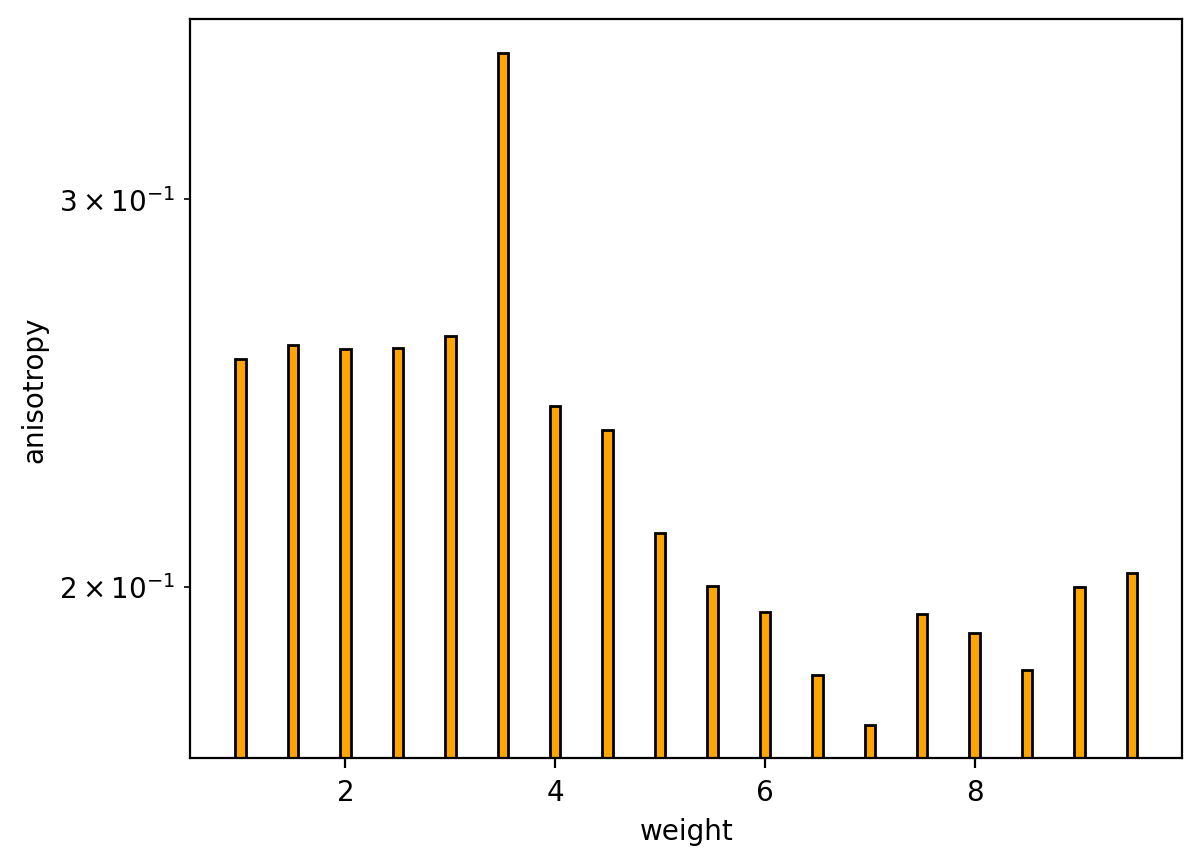

In [15]:
fig, ax = plt.subplots()

ax.bar(bts, aniso_cell_values, width=0.1, color='orange', edgecolor='black', linewidth=1, align='center')
ax.set_ylabel('anisotropy')
ax.set_xlabel('weight')
ax.set_yscale('log')
#ax.set_xlim(1.5, 4)
#ax.set_ylim(0.25, 0.3)
plt.savefig('../image/plot_aniso_weight.png', transparent=False)

In [16]:
sheet.edge_df

,srce,trgt,face,dx,dy,dz,nx,ny,nz,sx,...,uz,line_tension,weight,unique_id,weight_length,rx,ry,rz,weighted_length,num_sides
edge,,,,,,,,,,,,,,,,,,,,,
0,663,492,1598,0.129190,0.276801,0.025309,-0.084013,0.023458,0.172290,-3.639060,...,0.082571,0.01,1.000000,1,0.187637,0.464254,-0.338910,0.272526,0.306512,7
1,971,663,1598,0.832488,0.168327,0.392631,-0.178940,0.044594,0.360285,-4.471548,...,0.419613,0.01,1.000000,3,0.572184,-0.368234,-0.507237,-0.120105,0.935697,7
2,865,1815,813,-0.056708,-0.435667,0.170319,-0.272108,0.110244,0.191400,-6.352894,...,0.361456,0.01,1.781421,5,0.378270,-0.439576,-0.001920,-0.623827,0.839407,6
3,490,2507,341,-0.683561,-0.008872,-0.548903,-0.282735,0.092720,0.350597,-4.754560,...,-0.626090,0.01,0.173410,9,0.448401,0.445259,0.518677,0.221902,0.152032,6
4,2464,154,849,-0.926727,0.055787,0.955167,0.090590,-0.294423,0.105089,2.279095,...,0.717081,0.01,0.295567,10,0.577577,0.755040,0.067946,-0.460509,0.393701,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9685,336,3227,267,0.014281,-0.000488,-0.011024,-0.000512,-0.004035,-0.000485,0.279967,...,-0.610850,0.01,0.328638,823,0.651352,0.027815,0.032979,-0.304025,0.005931,7
9686,3228,974,1281,0.012740,-0.005626,0.005570,-0.005689,-0.008763,0.004160,-4.015476,...,0.371346,0.01,1.540643,2500,0.458397,0.567935,-0.577332,-0.439502,0.023110,5
9687,974,3228,1141,-0.012740,0.005626,-0.005570,-0.003044,-0.002666,0.004269,-4.002735,...,-0.371346,0.01,0.295567,658,0.578872,-0.162721,0.406949,0.138139,0.004433,6


In [ ]:
sheets_obj = {}
for i, above_threshold in enumerate(bts):
    
    print(f"{i+1} / {10}", end=" ")
    update_weights(
        sheet, 
        threshold_angle=theta, 
        below_threshold=0.5,
        above_threshold=above_threshold,
    )
    solver = QSSolver(with_t1=True, with_t3=False)
    res = solver.find_energy_min(sheet, geom, model, options={"gtol": 1e-4})
    sheet_copy = sheet.copy()
    sheets_obj[above_threshold] = sheet_copy



1 / 10 

/home/lglepin/miniforge3/envs/tyssue/lib/python3.10/site-packages/tyssue/topology/base_topology.py:196: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_vert_data[sheet.coords] = sheet.vert_df.loc[verts, sheet.coords].mean()
/home/lglepin/miniforge3/envs/tyssue/lib/python3.10/site-packages/tyssue/topology/base_topology.py:196: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_vert_data[sheet.coords] = sheet.vert_df.loc[verts, sheet.coords].mean()
/home/lglepin/miniforge3/envs/tyssue/lib/python3.10/site-packages/tyssue/topology/base_topology.py:196: FutureWarning: Series.__getitem__ treating keys as positions is depr

2 / 10 

/home/lglepin/miniforge3/envs/tyssue/lib/python3.10/site-packages/tyssue/topology/base_topology.py:196: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_vert_data[sheet.coords] = sheet.vert_df.loc[verts, sheet.coords].mean()
/home/lglepin/miniforge3/envs/tyssue/lib/python3.10/site-packages/tyssue/topology/base_topology.py:196: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_vert_data[sheet.coords] = sheet.vert_df.loc[verts, sheet.coords].mean()
/home/lglepin/miniforge3/envs/tyssue/lib/python3.10/site-packages/tyssue/topology/base_topology.py:196: FutureWarning: Series.__getitem__ treating keys as positions is depr

3 / 10 

/home/lglepin/miniforge3/envs/tyssue/lib/python3.10/site-packages/tyssue/topology/base_topology.py:196: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_vert_data[sheet.coords] = sheet.vert_df.loc[verts, sheet.coords].mean()


4 / 10 

/home/lglepin/miniforge3/envs/tyssue/lib/python3.10/site-packages/tyssue/topology/base_topology.py:196: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_vert_data[sheet.coords] = sheet.vert_df.loc[verts, sheet.coords].mean()
/home/lglepin/miniforge3/envs/tyssue/lib/python3.10/site-packages/tyssue/topology/base_topology.py:196: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_vert_data[sheet.coords] = sheet.vert_df.loc[verts, sheet.coords].mean()
/home/lglepin/miniforge3/envs/tyssue/lib/python3.10/site-packages/tyssue/topology/base_topology.py:196: FutureWarning: Series.__getitem__ treating keys as positions is depr

5 / 10 

/home/lglepin/miniforge3/envs/tyssue/lib/python3.10/site-packages/tyssue/topology/base_topology.py:196: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_vert_data[sheet.coords] = sheet.vert_df.loc[verts, sheet.coords].mean()
/home/lglepin/miniforge3/envs/tyssue/lib/python3.10/site-packages/tyssue/topology/base_topology.py:196: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_vert_data[sheet.coords] = sheet.vert_df.loc[verts, sheet.coords].mean()
/home/lglepin/miniforge3/envs/tyssue/lib/python3.10/site-packages/tyssue/topology/base_topology.py:196: FutureWarning: Series.__getitem__ treating keys as positions is depr

6 / 10 

/home/lglepin/miniforge3/envs/tyssue/lib/python3.10/site-packages/tyssue/topology/base_topology.py:196: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_vert_data[sheet.coords] = sheet.vert_df.loc[verts, sheet.coords].mean()
/home/lglepin/miniforge3/envs/tyssue/lib/python3.10/site-packages/tyssue/topology/base_topology.py:196: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_vert_data[sheet.coords] = sheet.vert_df.loc[verts, sheet.coords].mean()
/home/lglepin/miniforge3/envs/tyssue/lib/python3.10/site-packages/tyssue/topology/base_topology.py:196: FutureWarning: Series.__getitem__ treating keys as positions is depr

7 / 10 

/home/lglepin/miniforge3/envs/tyssue/lib/python3.10/site-packages/tyssue/topology/base_topology.py:196: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_vert_data[sheet.coords] = sheet.vert_df.loc[verts, sheet.coords].mean()
/home/lglepin/miniforge3/envs/tyssue/lib/python3.10/site-packages/tyssue/topology/base_topology.py:196: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_vert_data[sheet.coords] = sheet.vert_df.loc[verts, sheet.coords].mean()
/home/lglepin/miniforge3/envs/tyssue/lib/python3.10/site-packages/tyssue/topology/base_topology.py:196: FutureWarning: Series.__getitem__ treating keys as positions is depr

8 / 10 

/home/lglepin/miniforge3/envs/tyssue/lib/python3.10/site-packages/tyssue/topology/base_topology.py:196: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_vert_data[sheet.coords] = sheet.vert_df.loc[verts, sheet.coords].mean()
/home/lglepin/miniforge3/envs/tyssue/lib/python3.10/site-packages/tyssue/topology/base_topology.py:196: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_vert_data[sheet.coords] = sheet.vert_df.loc[verts, sheet.coords].mean()
/home/lglepin/miniforge3/envs/tyssue/lib/python3.10/site-packages/tyssue/topology/base_topology.py:196: FutureWarning: Series.__getitem__ treating keys as positions is depr

In [ ]:
fig, axes = plt.subplots(1, 10)

for i, (above_threshold, sheet_copy) in enumerate(sheets_obj.items()):
    #plt.savefig(f'sheet {i+1}.png', transparent=True)
    fig, ax = draw_half_sheet(sheet_copy, axes[i])
    ax.set_xlabel(f"{above_threshold:.3f}")
    ax.set_facecolor("black")
fig.set_size_inches(18, 5)
plt.show
plt.savefig('../image/aniso_weight.png', transparent=False)

In [ ]:
plt.savefig('../image/aniso_weight.png', transparent=True)

In [ ]:
from tyssue.io.hdf5 import save_datasets
save_datasets("../json_hdf5/polarity.hdf5",sheet)
from tyssue.config.json_parser import save_spec
save_spec(specs, "../json_hdf5/polarity.json", overwrite=True)